### Environment preparation 
 updating the required packages i.e. SageMaker Python SDK, pandas and numpy, and specifying:
1. The S3 bucket and prefix that you want to use for training and model data. This should be within the same region as the Notebook Instance or Studio, training, and hosting.
2. The IAM role ARN used to give training and hosting access to your data. See the documentation for how to create these. Note: if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with the appropriate full IAM role ARN string(s).
3. Download data from Kaggle 

In [ ]:
import sys

!{sys.executable} -m pip install pandas numpy --upgrade

In [5]:
import boto3
import sagemaker
from sagemaker import get_execution_role
import pandas as pd

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "sagemaker/titanic"
#role = get_execution_role()
role = 'arn:aws:iam::614511894774:user/xuefeng-admin'



In [ ]:
!kaggle competitions download -p ./data titanic 
import zipfile
zFile = zipfile.ZipFile('./data/titanic.zip', 'r')
zFile.extractall(path = './data')

### Pre-processing: Data Understanding
1. Import Libraries 

In [76]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices
import numpy as np


# Modelling Algorithms
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier , GradientBoostingClassifier

# Modelling Helpers
from sklearn.preprocessing import  Normalizer , scale, LabelEncoder
from sklearn.impute import SimpleImputer
#imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
from sklearn.model_selection import train_test_split , StratifiedKFold, cross_val_score,GridSearchCV
from sklearn.feature_selection import RFECV, SelectFromModel

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
sns.set_style( 'white' )
pylab.rcParams[ 'figure.figsize' ] = 8 , 6

2. Setup helper Functions

In [10]:
def plot_histograms( df , variables , n_rows , n_cols ):
    fig = plt.figure( figsize = ( 16 , 12 ) )
    for i, var_name in enumerate( variables ):
        ax=fig.add_subplot( n_rows , n_cols , i+1 )
        df[ var_name ].hist( bins=10 , ax=ax )
        ax.set_title( 'Skew: ' + str( round( float( df[ var_name ].skew() ) , ) ) ) # + ' ' + var_name ) #var_name+" Distribution")
        ax.set_xticklabels( [] , visible=False )
        ax.set_yticklabels( [] , visible=False )
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

def plot_distribution( df , var , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , hue=target , aspect=4 , row = row , col = col )
    facet.map( sns.kdeplot , var , shade= True )
    facet.set( xlim=( 0 , df[ var ].max() ) )
    facet.add_legend()

def plot_categories( df , cat , target , **kwargs ):
    row = kwargs.get( 'row' , None )
    col = kwargs.get( 'col' , None )
    facet = sns.FacetGrid( df , row = row , col = col )
    facet.map( sns.barplot , cat , target )
    facet.add_legend()
    
def plot_correlation_map( df ):
    corr = titanic.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

def describe_more( df ):
    var = [] ; l = [] ; t = []
    for x in df:
        var.append( x )
        l.append( len( pd.value_counts( df[ x ] ) ) )
        t.append( df[ x ].dtypes )
    levels = pd.DataFrame( { 'Variable' : var , 'Levels' : l , 'Datatype' : t } )
    levels.sort_values( by = 'Levels' , inplace = True )
    return levels

def plot_variable_importance( X , y ):
    tree = DecisionTreeClassifier( random_state = 99 )
    tree.fit( X , y )
    plot_model_var_imp( tree , X , y )
    
def plot_model_var_imp( model , X , y ):
    imp = pd.DataFrame( 
        model.feature_importances_  , 
        columns = [ 'Importance' ] , 
        index = X.columns 
    )
    imp = imp.sort_values( [ 'Importance' ] , ascending = True )
    imp[ : 10 ].plot( kind = 'barh' )
    print (model.score( X , y ))

3. Feature engineering
    - Overwie of Data shape/ features 
    - Check missing values 
    - replace missing values with avg/mod...- creat new features

In [60]:
train = pd.read_csv('./data/train.csv')
test  = pd.read_csv("./data/test.csv")

full = train.append( test , ignore_index = True )
titanic = full[ :891 ]

del train , test
# shpe of all data
print ('Datasets:' , 'full:' , full.shape , 'titanic:' , titanic.shape)

Datasets: full: (1309, 12) titanic: (891, 12)


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


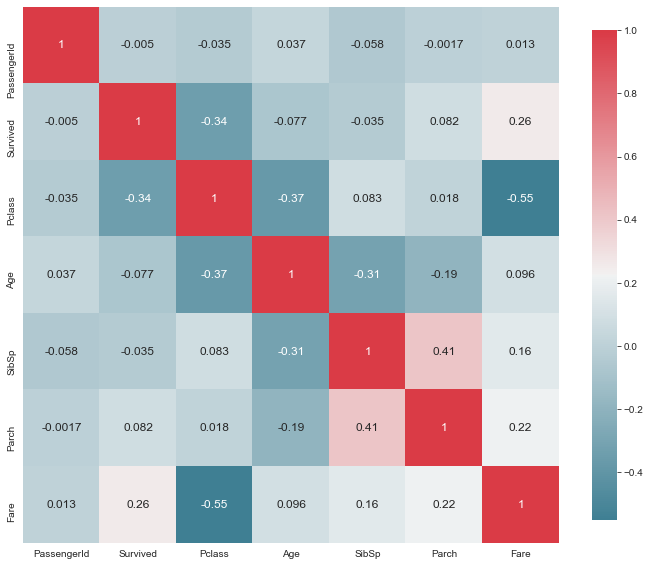

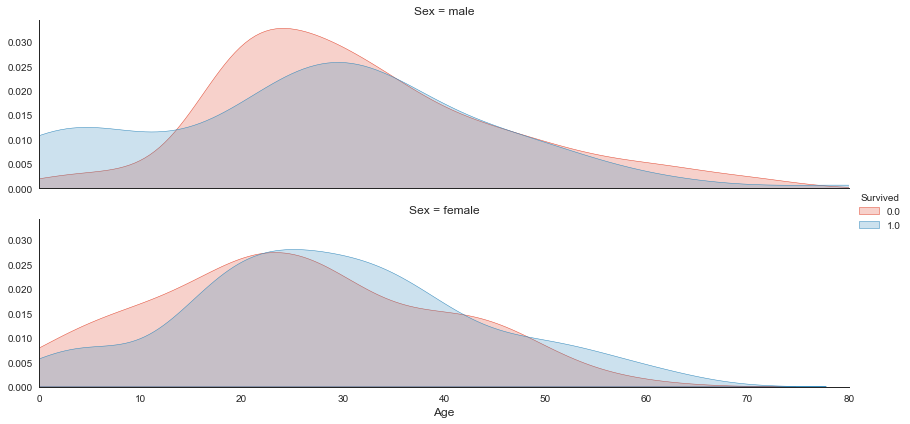

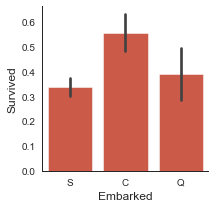

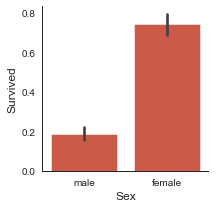

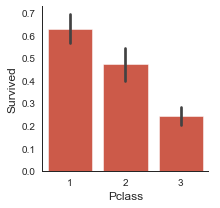

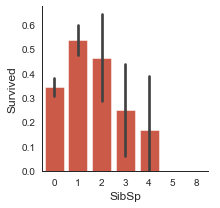

In [61]:
print(titanic.isnull().sum())
titanic.head()

# Plot heatmap by features
plot_correlation_map( titanic )

# Plot distribution rate by Sex and Embarked
plot_distribution( titanic , var = 'Age' , target = 'Survived' , row = 'Sex', )

# Plot survival rate by Embarked
plot_categories( titanic , cat = 'Embarked' , target = 'Survived' )

# Plot survival rate by Sex
plot_categories(titanic, cat='Sex', target='Survived')

# Plot survival rate by Pclass
plot_categories(titanic, cat='Pclass', target='Survived')

# Plot survival rate by SibSp
plot_categories(titanic, cat='SibSp', target='Survived')

In [62]:
# drop unnecessary features
full.drop(labels=['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# drop Nan rows for embarked 
full.dropna(subset=['Embarked'])

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,0.0,3,male,22.0,1,0,7.2500,NaN,S
1,1.0,1,female,38.0,1,0,71.2833,C85,C
2,1.0,3,female,26.0,0,0,7.9250,NaN,S
3,1.0,1,female,35.0,1,0,53.1000,C123,S
4,0.0,3,male,35.0,0,0,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...
1304,NaN,3,male,NaN,0,0,8.0500,NaN,S
1305,NaN,1,female,39.0,0,0,108.9000,C105,C
1306,NaN,3,male,38.5,0,0,7.2500,NaN,S
1307,NaN,3,male,NaN,0,0,8.0500,NaN,S


In [63]:
# Transform Sex into binary values 0 and 1
sex = pd.Series( np.where( full.Sex == 'male' , 1 , 0 ) , name = 'Sex' )

# Create a new variable for every unique value of Embarked
embarked = pd.get_dummies( full.Embarked , prefix='Embarked' )
embarked.head()

# Create a new variable for every unique value of Embarked
pclass = pd.get_dummies( full.Pclass , prefix='Pclass' )
pclass.head()

,Pclass_1,Pclass_2,Pclass_3
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,0,1


In [64]:
# Create dataset
imputed = pd.DataFrame()

# Fill missing values of Age with the average of Age (mean) and around to int()
imputed[ 'Age' ] = full.Age.fillna( full.Age.mean() )
imputed['Age'] = imputed['Age'].apply(lambda x:int(x))
# Fill missing values of Fare with the average of Fare (mean) and around to int()
imputed[ 'Fare' ] = full.Fare.fillna( full.Fare.mean() )
imputed['Fare'] = imputed['Fare'].apply(lambda x:int(x))

In [65]:
# Extract Cabin category information from the Cabin number
cabin = pd.DataFrame()

# replacing missing cabins with U (for Uknown)
cabin[ 'Cabin' ] = full.Cabin.fillna( 'U' )

# mapping each Cabin value with the cabin letter
cabin[ 'Cabin' ] = cabin[ 'Cabin' ].map( lambda c : c[0] )

# dummy encoding ...
cabin = pd.get_dummies( cabin['Cabin'] , prefix = 'Cabin' )

In [66]:
# Create family size and category for family size
family = pd.DataFrame()

# introducing a new feature : the size of families (including the passenger)
family[ 'FamilySize' ] = full[ 'Parch' ] + full[ 'SibSp' ] + 1

# introducing other features based on the family size
family[ 'Family_Single' ] = family[ 'FamilySize' ].map( lambda s : 1 if s == 1 else 0 )
family[ 'Family_Small' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 2 <= s <= 4 else 0 )
family[ 'Family_Large' ]  = family[ 'FamilySize' ].map( lambda s : 1 if 5 <= s else 0 )
family.head()

,FamilySize,Family_Single,Family_Small,Family_Large
0,2,0,1,0
1,2,0,1,0
2,1,1,0,0
3,2,0,1,0
4,1,1,0,0


4. Assemble final datasets for modelling
    -  Variable selection
    - Create datasets
    - Feature importance

In [67]:
# Select which features/variables to include in the dataset from the list below:
# imputed , embarked , pclass , sex , family , cabin 

full_X = pd.concat( [ imputed , embarked , cabin , sex, family ] , axis=1 )

# Create all datasets that are necessary to train, validate and test models
train_valid_X = full_X[ 0:891 ]
train_valid_y = titanic.Survived
test_X = full_X[ 891: ]
train_X , valid_X , train_y , valid_y = train_test_split( train_valid_X , train_valid_y , train_size = .7 )

print (full_X.shape , train_X.shape , valid_X.shape , train_y.shape , valid_y.shape , test_X.shape)

(1309, 19) (623, 19) (268, 19) (623,) (268,) (418, 19)


### Modeling
1. Model Selection

(623, 19)


'\n# reduce the features both in train-test datasets\nmodel = SelectFromModel(clf, prefit=True)\ntrain_reduced = model.transform(train_X)\nprint(train_reduced.shape)\n# (891L, 14L)\n\ntest_reduced = model.transform(test_X)\nprint(test_reduced.shape)\n# (418L, 14L)\n'

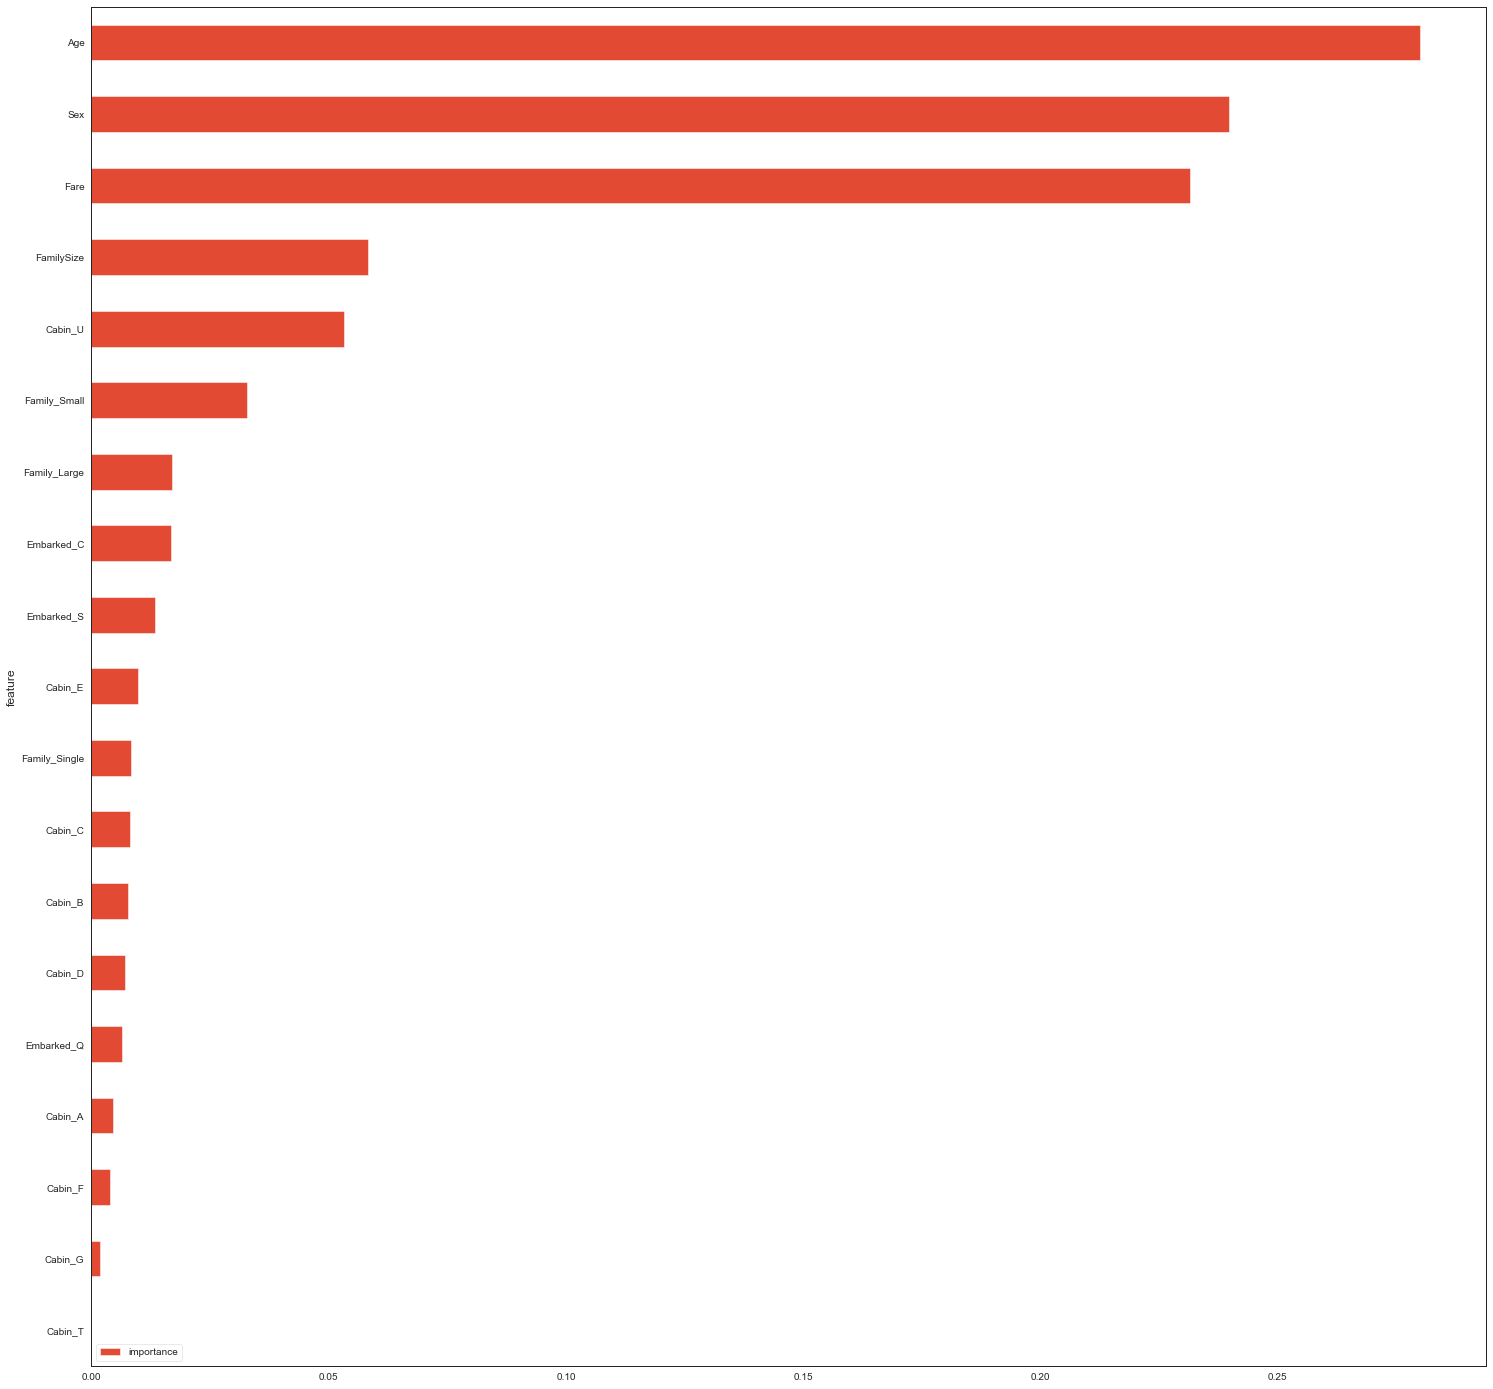

In [73]:
# Before training, see the importance of the features, reducing fearures for the purpose of overfitting-minimize

clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(train_X, train_y)

features = pd.DataFrame()
features['feature'] = train_X.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='barh', figsize=(25, 25))
print(train_X.shape)
# (891L, 14L)

'''
# reduce the features both in train-test datasets
model = SelectFromModel(clf, prefit=True)
train_reduced = model.transform(train_X)
print(train_reduced.shape)
# (891L, 14L)

test_reduced = model.transform(test_X)
print(test_reduced.shape)
# (418L, 14L)
'''

In [74]:
# define a function to get score from cross-validation
def compute_score(clf, X, y, scoring='accuracy'):
    xval = cross_val_score(clf, X, y, cv = 5, scoring=scoring)
    return np.mean(xval)

In [75]:
#Random Forests Model
model_rf = RandomForestClassifier(n_estimators=100)

#Support Vector Machines
model_SVC = SVC()

#Gradient Boosting Classifier
model_gboost = GradientBoostingClassifier()

#K-nearest neighbors
model_knn = KNeighborsClassifier(n_neighbors = 3)

#Gaussian Naive Bayes
model_gaussianNB = GaussianNB()

#Logistic Regression
model_logreg = LogisticRegression()

models = [model_rf, model_SVC, model_gboost, model_knn, model_gaussianNB,model_logreg]

for model in models:
    print('Cross-validation of : {0}'.format(model.__class__))
    score = compute_score(clf=model, X=train_X, y=train_y, scoring='accuracy')
    print('CV score = {0}'.format(score))
    print('****')



Cross-validation of : <class 'sklearn.ensemble._forest.RandomForestClassifier'>
CV score = 0.7832774193548387
****
Cross-validation of : <class 'sklearn.svm._classes.SVC'>
CV score = 0.675741935483871
****
Cross-validation of : <class 'sklearn.ensemble._gb.GradientBoostingClassifier'>
CV score = 0.8169290322580645
****
Cross-validation of : <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
CV score = 0.6838451612903225
****
Cross-validation of : <class 'sklearn.naive_bayes.GaussianNB'>
CV score = 0.7207096774193549
****
Cross-validation of : <class 'sklearn.linear_model._logistic.LogisticRegression'>
CV score = 0.8137677419354838
****


In [77]:
# turn run_gs to True if you want to run the gridsearch again.
run_gs = False

if run_gs:
    parameter_grid = {
                 'max_depth' : [4, 6, 8],
                 'n_estimators': [50, 10],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 'min_samples_split': [2, 3, 10],
                 'min_samples_leaf': [1, 3, 10],
                 'bootstrap': [True, False],
                 }
    forest = RandomForestClassifier()
    cross_validation = StratifiedKFold(n_splits=5)

    grid_search = GridSearchCV(forest,
                               scoring='accuracy',
                               param_grid=parameter_grid,
                               cv=cross_validation,
                               verbose=1
                              )

    grid_search.fit(train_X, train_y)
    model = grid_search
    parameters = grid_search.best_params_

    print('Best score: {}'.format(grid_search.best_score_))
    print('Best parameters: {}'.format(grid_search.best_params_))
    
else: 
    parameters = {'bootstrap': False, 'min_samples_leaf': 3, 'n_estimators': 50, 
                  'min_samples_split': 10, 'max_features': 'sqrt', 'max_depth': 6}
    
    model = RandomForestClassifier(**parameters)
    model.fit(train_X, train_y)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best score: 0.8314451612903226
Best parameters: {'bootstrap': True, 'max_depth': 6, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}


In [78]:
score = compute_score(clf=model, X=train_X, y=train_y, scoring='accuracy')
print('CV score = {}'.format(score))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Fitting 5 folds for each of 324 candidates, totalling 1620 fits
CV score = 0.8104774193548387


In [53]:

'''
    load data to S3
'''
inputs = sess.upload_data(path="./data", bucket=bucket, key_prefix=prefix)
print("input spec (in this case, just an S3 path): {}".format(inputs))

output_location = "s3://{}/{}/output".format(bucket, prefix)
print("training artifacts will be uploaded to: {}".format(output_location))

input spec (in this case, just an S3 path): s3://sagemaker-eu-central-1-614511894774/sagemaker/titanic
training artifacts will be uploaded to: s3://sagemaker-eu-central-1-614511894774/sagemaker/titanic/output


In [54]:
!kaggle competitions list


zsh:1: command not found: kaggle


In [55]:
!ls

README.md            kaggle-titanic.ipynb
data                 kaggle.json


In [56]:
!mkdir ~/.kaggle
!mv kaggle.json ../.kaggle/

mv: rename kaggle.json to ../.kaggle/: No such file or directory
